In [1]:
x=1

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import squidpy as sq
import anndata as ad
from matplotlib import pyplot as plt
from pprint import pprint
from utils import find_closest_points, split_train_test, split_train_test_by_coordinates

In [13]:
type_dict = {
    'lipids': ['V11L12-038_A1', 'V11L12-038_B1'],
    'metabolites': ['V11L12-038_D1'],
    'neurotransmitters': ['V11L12-109_A1', 'V11L12-109_B1'], #'V11L12-109_C1'],
}

In [14]:
MSI_TYPE = 'neurotransmitters'
N_HVG = 2000
N_HVM = 500

In [15]:
slides = type_dict[MSI_TYPE]
slides

['V11L12-109_A1', 'V11L12-109_B1']

In [16]:
def pp(adata):
    adata.X = adata.layers['counts'].copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    sq.gr.spatial_neighbors(adata)
    sq.gr.spatial_autocorr(adata, genes=adata.var_names, attr='X', mode='moran')

In [17]:
rna_adatas = []
msi_adatas = []
spatial_hvg = []
spatial_hvm = []

for slide in slides:
    print(f'slide {slide}')
    adata_msi = sc.read(f'../datasets/{slide}.MSI_MOSCOT.h5ad')
    adata_rna = sc.read(f'../datasets/{slide}.RNA_MOSCOT.h5ad')

    adata_msi.layers['counts'] = adata_msi.obsm['raw_counts'].copy()
    del adata_msi.obsm['raw_counts']

    adata_rna.layers['counts'] = adata_rna.obsm['raw_counts'].copy()
    del adata_rna.obsm['raw_counts']
    
    if 'spatial' in adata_msi.uns.keys():
        del(adata_msi.uns['spatial'])  # need to delete so scanpy doesn't try to read it

    # match spots
    spatial_var = adata_rna.uns['moranI'].index
    matching_df, matching_rna, matching_msi = find_closest_points(
        adata_rna[:, spatial_var], adata_msi[:, adata_msi.var['highly_variable']])
    print(f'number of spots in RNA: {len(adata_rna)}')
    print(f'number of spots in MSI: {len(adata_msi)}')
    print(f'number of non-unique matchings: {len(adata_msi) - len(np.unique(matching_df["closest_adata_rna_index"]))}')

    adata_msi = adata_msi[matching_df['adata_msi_index']].copy()
    adata_rna = adata_rna[matching_df['closest_adata_rna_index']].copy()
    
    # random split
    _, _, _, _ = split_train_test(matching_rna, matching_msi, matching_df=matching_df)
    adata_rna.obs['random_split'] = matching_df['split'].values
    adata_msi.obs['random_split'] = matching_df['split'].values

    # half split
    _, _, _, _ = split_train_test_by_coordinates(matching_rna, matching_msi, matching_df)
    adata_rna.obs['half_split'] = matching_df['split'].values
    adata_msi.obs['half_split'] = matching_df['split'].values
    
    adata_rna.obs['og_index'] = adata_rna.obs_names
    adata_rna.obs_names = adata_msi.obs_names

    adata_rna.obs['slide'] = slide
    adata_msi.obs['slide'] = slide

    # rna pp
    pp(adata_rna)

    # msi pp
    pp(adata_msi)

    adata_rna.write(f'../datasets/{slide}.RNA_MOSCOT_paired.h5ad')
    adata_msi.write(f'../datasets/{slide}.MSI_MOSCOT_paired.h5ad')
    
    rna_adatas.append(adata_rna)
    msi_adatas.append(adata_msi)

    spatial_hvg.append(adata_rna.uns['moranI'][:N_HVG].index.values)
    spatial_hvm.append(adata_msi.uns['moranI'][:N_HVM].index.values)

slide V11L12-109_A1
number of spots in RNA: 2471
number of spots in MSI: 2438
number of non-unique matchings: 356


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


slide V11L12-109_B1
number of spots in RNA: 2950
number of spots in MSI: 3005
number of non-unique matchings: 450


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
common_spatial_hvg = set(spatial_hvg[0])
for slide_spatial_hvg in spatial_hvg[1:]:
    common_spatial_hvg = common_spatial_hvg.intersection(set(slide_spatial_hvg))
len(common_spatial_hvg)

1131

In [19]:
common_spatial_hvm = set(spatial_hvm[0])
for slide_spatial_hvm in spatial_hvm[1:]:
    common_spatial_hvm = common_spatial_hvm.intersection(set(slide_spatial_hvm))
len(common_spatial_hvm)

342

### check the intersection between hvg and spatial hvg

In [20]:
spatial_hvg = adata_rna.uns['moranI'][:N_HVG].index.values

In [21]:
hvg = adata_rna[:,adata_rna.var['highly_variable']].var.index.values

In [22]:
len(set(spatial_hvg).difference(set(hvg)))

1386

In [23]:
differet_hvgs = set(spatial_hvg).difference(set(hvg))

In [24]:
genes = adata_rna.uns['moranI'].loc[list(differet_hvgs)].sort_values('I')[-10:].index.values

In [25]:
#adata_rna.X = adata_rna.layers['']

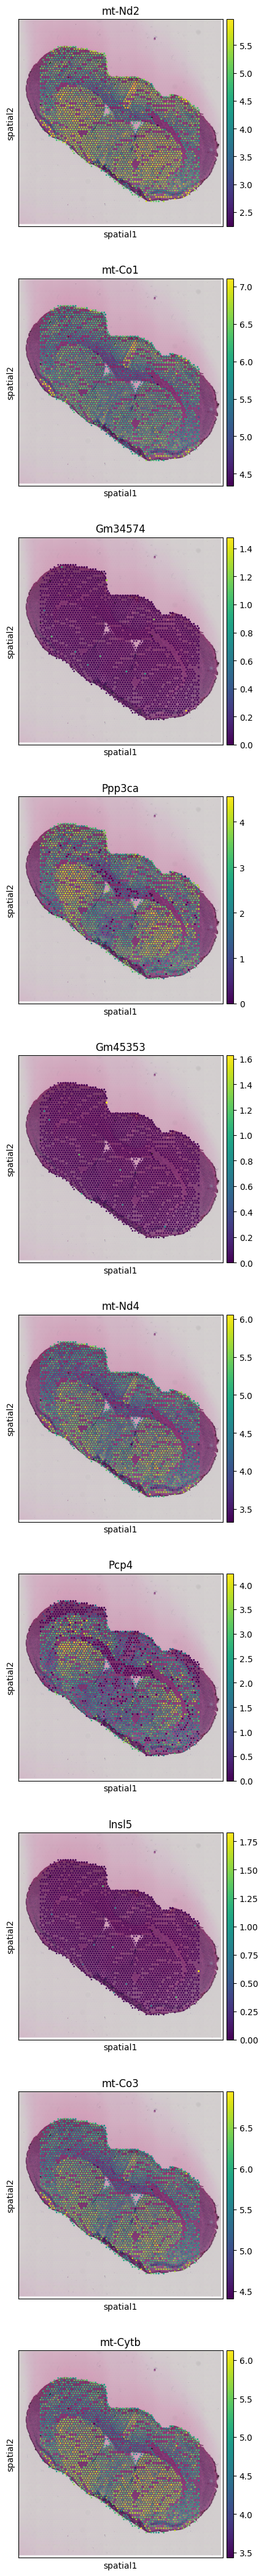

In [26]:
sq.pl.spatial_scatter(adata_rna, color=genes, ncols=1)

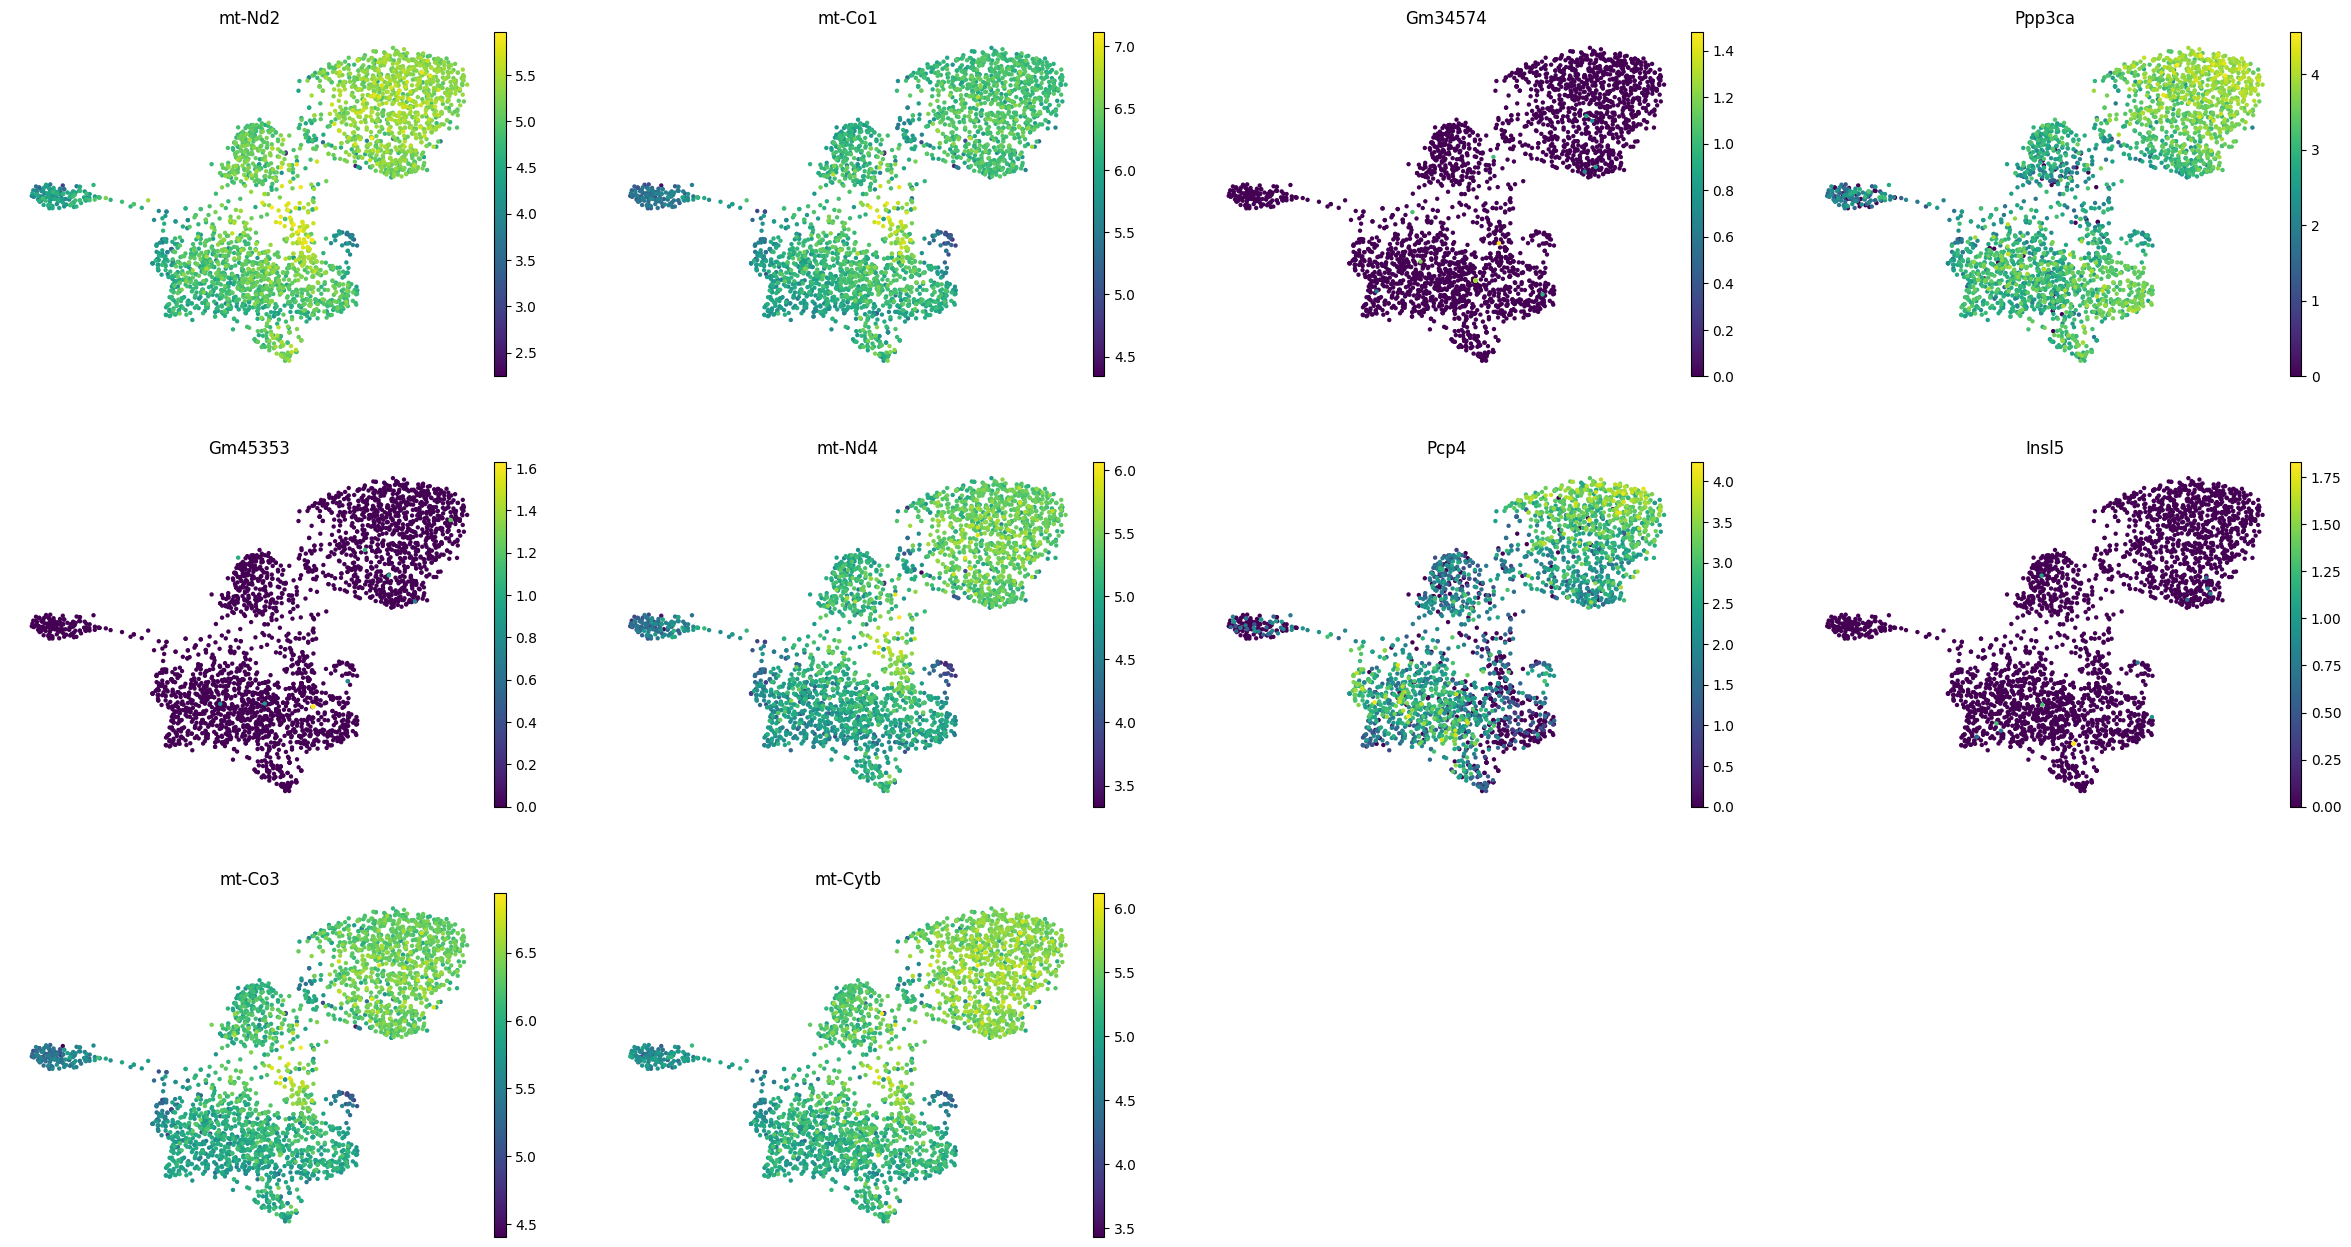

In [27]:
sc.pl.umap(adata_rna, color=genes, frameon=False)

## RNA

In [28]:
rna_adata = ad.concat(rna_adatas)
rna_adata

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5443 × 13922
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'clusters', 'technology', 'random_split', 'half_split', 'og_index', 'slide'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    layers: 'counts'

In [29]:
sc.pp.highly_variable_genes(rna_adata, flavor='seurat', n_top_genes=N_HVG, batch_key='slide')

In [30]:
sc.pp.pca(rna_adata)
sc.pp.neighbors(rna_adata)
sc.tl.umap(rna_adata)
sc.tl.leiden(rna_adata, key_added='gex_concat_clusters')

/tmp/ipykernel_744370/2446268108.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna_adata, key_added='gex_concat_clusters')


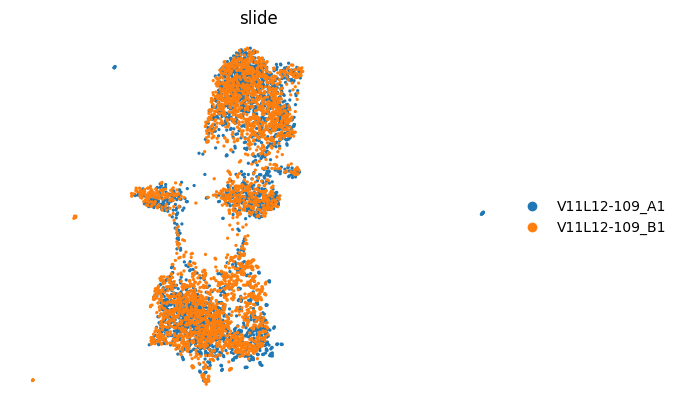

In [31]:
sc.pl.umap(rna_adata, color=['slide'], frameon=False)

In [32]:
rna_adata.var['spatialy_highly_variable'] = rna_adata.var_names.isin(common_spatial_hvg)
rna_adata

AnnData object with n_obs × n_vars = 5443 × 13922
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'clusters', 'technology', 'random_split', 'half_split', 'og_index', 'slide', 'gex_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'gex_concat_clusters', 'slide_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [33]:
rna_adata.var['gex_highly_variable'] = rna_adata.var['highly_variable'].copy()
rna_adata.var['highly_variable'] = rna_adata.var['spatialy_highly_variable'].copy()

In [34]:
sc.pp.pca(rna_adata)
sc.pp.neighbors(rna_adata)
sc.tl.umap(rna_adata)

In [35]:
rna_adata.var['highly_variable'] = rna_adata.var['gex_highly_variable'].copy()

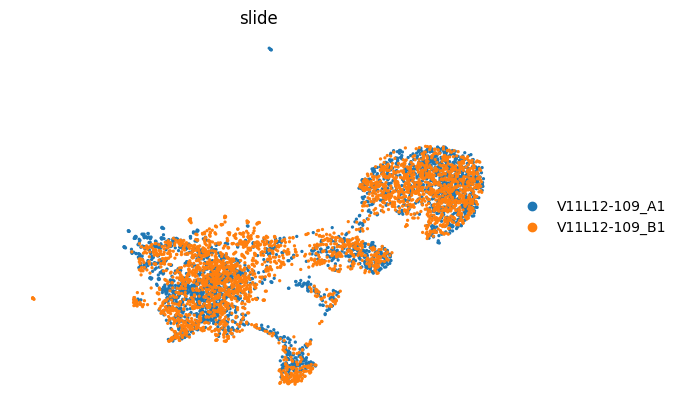

In [36]:
sc.pl.umap(rna_adata, color=['slide'], frameon=False)

In [37]:
rna_adata.write(f'../datasets/RNA_concat_{MSI_TYPE}.h5ad')

## MSI

In [38]:
msi_adata = ad.concat(msi_adatas)
msi_adata

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    layers: 'counts'

In [39]:
sc.pp.highly_variable_genes(msi_adata, flavor='seurat', n_top_genes=N_HVM, batch_key='slide')

In [40]:
sc.pp.pca(msi_adata)
sc.pp.neighbors(msi_adata)
sc.tl.umap(msi_adata)
sc.tl.leiden(msi_adata, key_added='msi_concat_clusters')

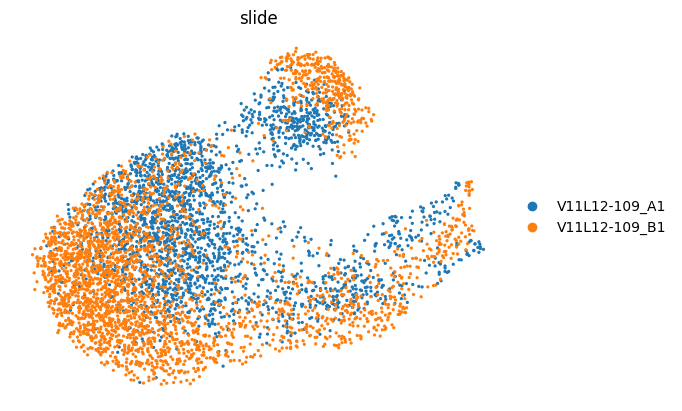

In [41]:
sc.pl.umap(msi_adata, color=['slide'], frameon=False)

In [42]:
msi_adata.var['spatialy_highly_variable'] = msi_adata.var_names.isin(common_spatial_hvm)
msi_adata

AnnData object with n_obs × n_vars = 5443 × 1538
    obs: 'technology', 'clusters', 'random_split', 'half_split', 'slide', 'msi_concat_clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'spatialy_highly_variable'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'msi_concat_clusters', 'slide_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_warp'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [43]:
msi_adata.var['msi_highly_variable'] = msi_adata.var['highly_variable'].copy()
msi_adata.var['highly_variable'] = msi_adata.var['spatialy_highly_variable'].copy()

In [44]:
sc.pp.pca(msi_adata)
sc.pp.neighbors(msi_adata)
sc.tl.umap(msi_adata)

In [45]:
msi_adata.var['highly_variable'] = msi_adata.var['msi_highly_variable'].copy()

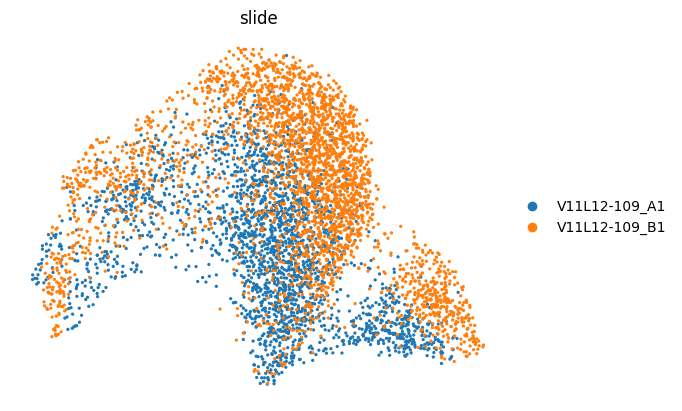

In [46]:
sc.pl.umap(msi_adata, color=['slide'], frameon=False)

In [47]:
msi_adata.write(f'../datasets/MSI_concat_{MSI_TYPE}.h5ad')